In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 7.5 # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 30
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 1000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

30000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

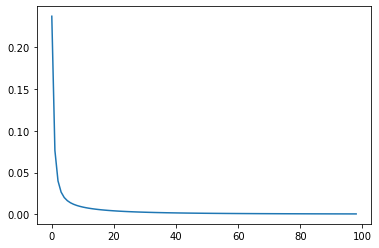

In [8]:
plt.plot(S)

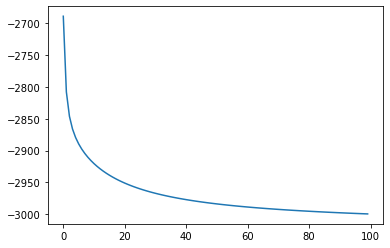

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0003708482194933822

In [11]:
eta

array([-2689.28934434, -2808.00699154, -2846.2672245 , -2866.22243691,
       -2879.49383738, -2889.52406314, -2897.65878682, -2904.53845129,
       -2910.51418866, -2915.79961381, -2920.53529932, -2924.81953375,
       -2928.72439017, -2932.30475501, -2935.6037139 , -2938.65592944,
       -2941.48985197, -2944.12922069, -2946.59411621, -2948.90171951,
       -2951.06687309, -2953.10250487, -2955.01995481, -2956.82923093,
       -2958.53921301, -2960.15781696, -2961.69212901, -2963.14851647,
       -2964.53272004, -2965.84993133, -2967.10485863, -2968.30178286,
       -2969.44460569, -2970.53689103, -2971.58190095, -2972.58262711,
       -2973.54181814, -2974.46200373, -2975.3455159 , -2976.19450776,
       -2977.0109702 , -2977.79674669, -2978.55354649, -2979.28295653,
       -2979.98645194, -2980.6654056 , -2981.32109671, -2981.9547185 ,
       -2982.56738521, -2983.16013841, -2983.7339527 , -2984.28974097,
       -2984.82835906, -2985.35061008, -2985.85724836, -2986.34898303,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([3.10110656e+02, 1.91393008e+02, 1.53132776e+02, 1.33177563e+02,
       1.19906163e+02, 1.09875937e+02, 1.01741213e+02, 9.48615487e+01,
       8.88858114e+01, 8.36003862e+01, 7.88647007e+01, 7.45804663e+01,
       7.06756099e+01, 6.70952450e+01, 6.37962861e+01, 6.07440706e+01,
       5.79101481e+01, 5.52707793e+01, 5.28058838e+01, 5.04982805e+01,
       4.83331269e+01, 4.62974952e+01, 4.43800452e+01, 4.25707691e+01,
       4.08607870e+01, 3.92421831e+01, 3.77078710e+01, 3.62514836e+01,
       3.48672800e+01, 3.35500687e+01, 3.22951414e+01, 3.10982172e+01,
       2.99553943e+01, 2.88631090e+01, 2.78180991e+01, 2.68173729e+01,
       2.58581819e+01, 2.49379963e+01, 2.40544841e+01, 2.32054923e+01,
       2.23890298e+01, 2.16032533e+01, 2.08464535e+01, 2.01170435e+01,
       1.94135481e+01, 1.87345944e+01, 1.80789033e+01, 1.74452815e+01,
       1.68326148e+01, 1.62398616e+01, 1.56660473e+01, 1.51102591e+01,
       1.45716410e+01, 1.40493900e+01, 1.35427517e+01, 1.30510170e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_7.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_7.csv', alpha, delimiter = ',')